In [10]:
from datalib import InputPath
import torch

attn_path = InputPath(
    "s3://synthesia-rnd-eun1-experiments/ditwo/kaiwen/PG008_inspect/attn_maps_first_and_last_4_frames.pt"
).resolve()
attn_map = torch.load(attn_path)

In [11]:
attn_map[0].shape

torch.Size([1, 7800, 7800])

Using approximate segment boundaries: [1560, 3120, 4680, 6240, 7800]


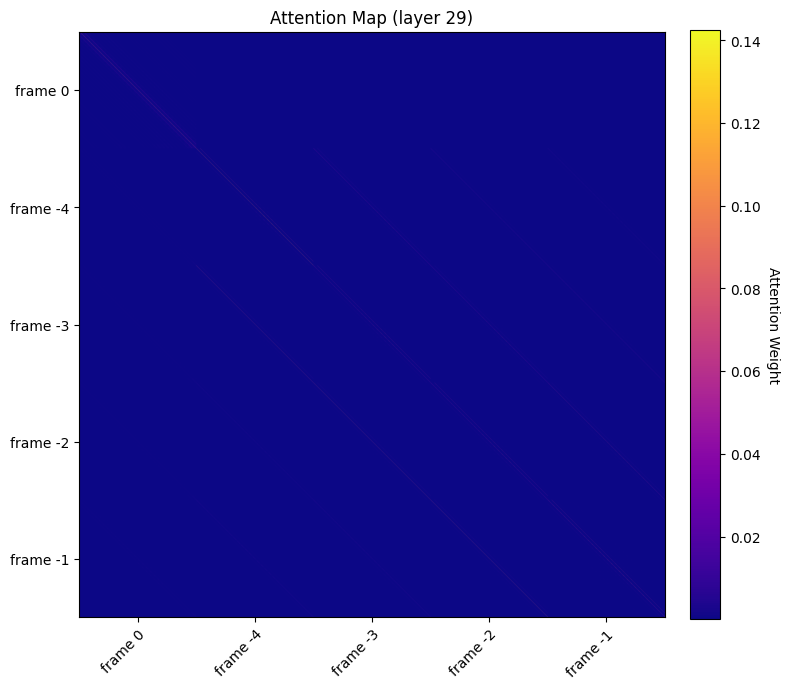

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


def visualize_attention_map(
    attention_map_tensor, segment_labels=None, segment_boundaries=None, title="Attention Map", layer=None, cmap="Reds"
):
    """
    Visualizes a square attention map tensor.

    Args:
        attention_map_tensor (torch.Tensor): The attention map tensor of shape [1, 1, N, N] or [N, N].
        segment_labels (list): A list of strings for labeling the segments (e.g., ["frame 0", "frame 1", "text"]).
        segment_boundaries (list, optional): A list of integers defining the ENDING index of each segment.
                                             If None, assumes equal division based on the number of labels.
                                             The length of this list should be equal to len(segment_labels).
                                             The last value should be the total sequence length (N).
                                             Example: For N=100 and 3 segments, could be [30, 70, 100].
        title (str): The title for the plot.
        cmap (str): The colormap to use for the heatmap (e.g., 'Reds', 'viridis', 'plasma').
    """
    # --- Data Preparation ---
    # 1. Ensure tensor is 2D [N, N]
    if attention_map_tensor.ndim == 4:
        if attention_map_tensor.shape[0] == 1 and attention_map_tensor.shape[1] == 1:
            attention_map = attention_map_tensor.squeeze(0).squeeze(0)
        else:
            # You might need to average over heads/batch if shape is different
            # For now, raise an error or take the first one
            raise ValueError(
                f"Input tensor shape {attention_map_tensor.shape} not handled. Expected [1, 1, N, N] or [N, N]."
            )
    elif attention_map_tensor.ndim == 2:
        attention_map = attention_map_tensor
    else:
        raise ValueError(f"Input tensor must be 2D or 4D, but got {attention_map_tensor.ndim}D.")

    seq_len = attention_map.shape[0]
    if attention_map.shape[0] != attention_map.shape[1]:
        raise ValueError(f"Attention map must be square, but got shape {attention_map.shape}.")

    # 2. Move to CPU and convert to NumPy
    if attention_map.is_cuda:
        attention_map = attention_map.cpu()
    attention_map_np = attention_map.detach().float().numpy()

    # --- Ticks and Labels ---
    num_segments = len(segment_labels)
    if segment_boundaries is None:
        print("Warning: segment_boundaries not provided. Assuming equal division.")
        # Calculate approximate boundaries assuming equal segments
        boundaries = np.linspace(0, seq_len, num_segments + 1, dtype=int)
        segment_boundaries = boundaries[1:]  # Ending index of each segment
    elif len(segment_boundaries) != num_segments:
        raise ValueError("Length of segment_boundaries must match length of segment_labels.")
    elif segment_boundaries[-1] != seq_len:
        raise ValueError(
            f"The last segment boundary ({segment_boundaries[-1]}) must match the sequence length ({seq_len})."
        )

    # Calculate tick positions (centers of segments)
    tick_positions = []
    start_idx = 0
    for end_idx in segment_boundaries:
        tick_positions.append(start_idx + (end_idx - start_idx) / 2)
        start_idx = end_idx

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(8, 8))  # Adjust figsize as needed

    # Use imshow for the heatmap
    im = ax.imshow(
        attention_map_np, cmap=cmap, aspect="equal", origin="upper"
    )  # origin='upper' matches matrix indexing

    # Set ticks and labels
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(segment_labels)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels(segment_labels)

    # Rotate x-axis labels if they overlap
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("Attention Weight", rotation=-90, va="bottom")

    # Set title
    ax.set_title(title + f" (layer {layer})")

    # Improve layout
    fig.tight_layout()

    # Show plot
    plt.show()


# 1. Get sequence length
seq_len = attn_map[0].size(-1)

# 2. Define segment labels (matching the example figure)
labels = ["frame 0", "frame -4", "frame -3", "frame -2", "frame -1"]

# 3. Define segment boundaries (IMPORTANT: Replace with your *actual* boundaries if known)
#    Assuming roughly equal division for this example:
num_segments = len(labels)
# Using linspace ensures the last boundary is exactly seq_len
approx_boundaries = np.linspace(0, seq_len, num_segments + 1, dtype=int)[1:]
print(f"Using approximate segment boundaries: {approx_boundaries.tolist()}")

# 4. Visualize
layer = 29
attention_map = attn_map[layer].unsqueeze(1)
visualize_attention_map(
    attention_map_tensor=attention_map,
    segment_labels=labels,
    segment_boundaries=approx_boundaries.tolist(),  # Or use known_boundaries
    title="Attention Map",
    layer=layer,
    cmap="plasma",  # Colormap similar to the example
)

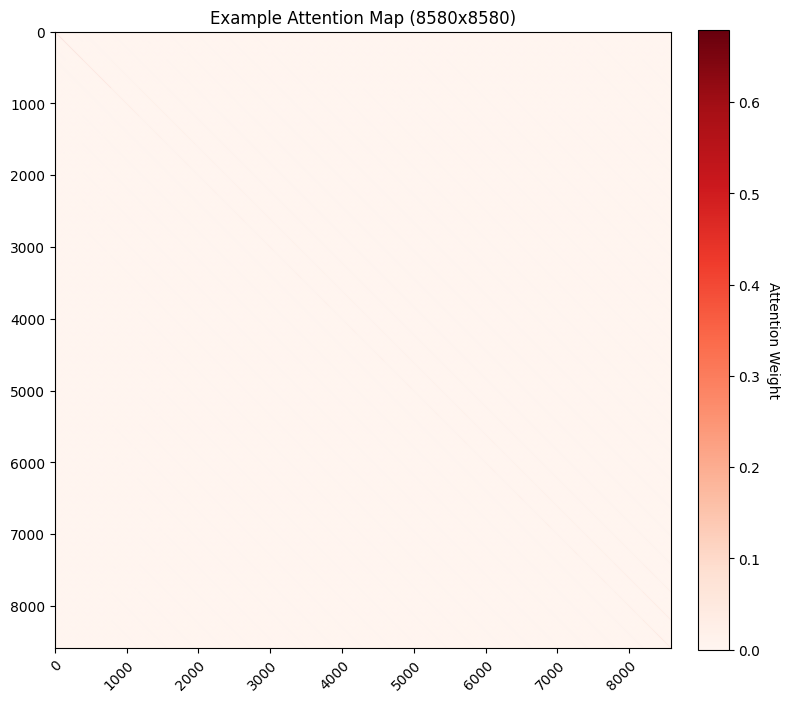

In [11]:
# visualize 2nd layer
second_layer_attn_map = attn_map[1]
visualize_attention_map(
    attention_map_tensor=second_layer_attn_map,
    # segment_labels=labels,
    # segment_boundaries=approx_boundaries.tolist(),  # Or use known_boundaries
    title="Example Attention Map (8580x8580)",
    cmap="Reds",  # Colormap similar to the example
)

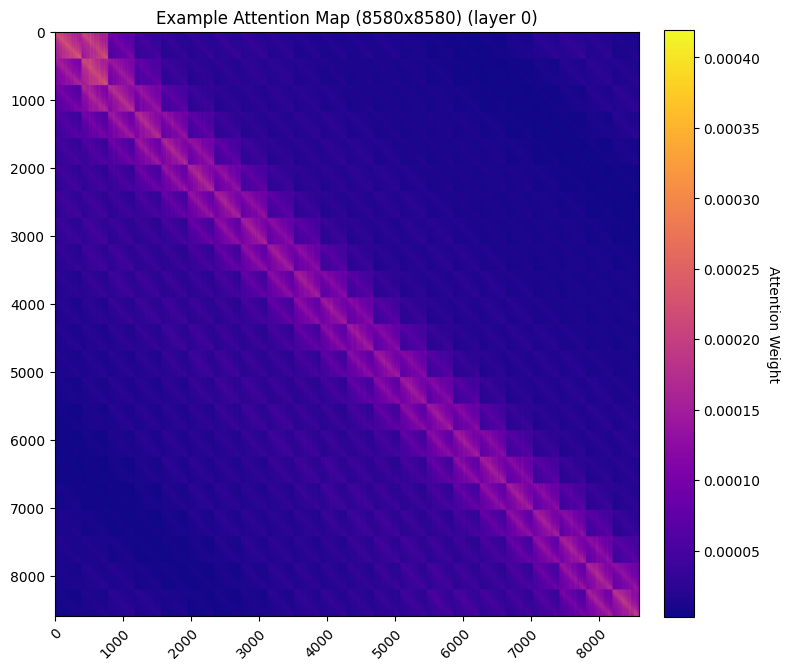

In [71]:
# visualize 2nd last layer
layer_idx = 0
layer_attn_map = attn_map[layer_idx]
visualize_attention_map(
    attention_map_tensor=layer_attn_map,
    # segment_labels=labels,
    # segment_boundaries=approx_boundaries.tolist(),  # Or use known_boundaries
    title="Example Attention Map (8580x8580)",
    layer=str(layer_idx),
    cmap="plasma",  # Colormap similar to the example
)


In [43]:
layer_attn_map.min(), layer_attn_map.max()
flat_index = torch.argmax(layer_attn_map)
row_index = flat_index // layer_attn_map.shape[-1]
col_index = flat_index % layer_attn_map.shape[-1]
row_index, col_index, layer_attn_map[:, :, row_index, col_index]


(tensor(4491, device='cuda:0'),
 tensor(4491, device='cuda:0'),
 tensor([[0.3809]], device='cuda:0', dtype=torch.bfloat16))

In [45]:
flat_attn_map = layer_attn_map.view(-1)
top_k_values, top_k_flat_indices = torch.topk(flat_attn_map, k=10)
top_k_values, top_k_flat_indices

(tensor([0.3809, 0.3359, 0.2891, 0.2871, 0.2852, 0.2773, 0.2715, 0.2695, 0.2656,
         0.2656], device='cuda:0', dtype=torch.bfloat16),
 tensor([38537271, 25579961, 51348704, 57707225, 25434084, 29141076, 65867756,
         12193601, 27699468, 29595869], device='cuda:0'))